# Отток клиентов

**Цель работы**: пострить модель предсказания ухода клиента из банка.

**Задачи**: пострить модель с предельно большим значением *F1*-меры, измерить значение *AUC-ROC*

До начала работы импортируем все необходимые библиотеки

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import numpy as np
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import precision_recall_curve

Создадим для удобства неизменяемую переменную, которая будет единой для всех, равной значению random_state

In [4]:
RS = 12345

## Подготовка данных

Загрузим датасет и просмотрим основную информацию о таблице

In [5]:
data = pd.read_csv('/datasets/Churn.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Посмотрим, как выглядит таблица.

In [7]:
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Из описания данных:

Признаки

    RowNumber — индекс строки в данных
    CustomerId — уникальный идентификатор клиента
    Surname — фамилия
    CreditScore — кредитный рейтинг
    Geography — страна проживания
    Gender — пол
    Age — возраст
    Tenure — сколько лет человек является клиентом банка
    Balance — баланс на счёте
    NumOfProducts — количество продуктов банка, используемых клиентом
    HasCrCard — наличие кредитной карты
    IsActiveMember — активность клиента
    EstimatedSalary — предполагаемая зарплата

Целевой признак

    Exited — факт ухода клиента

**Промежуточные выводы**: таблица исходных данных состоит из 14 столбцов и 10 000 строк, в которой содержатся данные типов float, object, int. Можно увидеть, что в столбце 'Tenure' содержатся пропуски. Названия столбцов с "верблюжьим оформлением", но в целом. все выполнено в одном стиле, можно оставить их как есть.

Проверим таблицу на пропуски

In [8]:
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

**Промежуточные выводы**: в столбце 'Tenure', как и ожидалось, имеются пропуски значений (909). Стоблец 'Tenure' соответствует количеству лет использования услуг банка клиентом. Скорее всего их можно заменить средним значением. Для этого нужно посмотреть их распределение.

Проверим таблицу на наличие явных дубликатов

In [9]:
print('Явных дубликатов в таблице:', data.duplicated().sum())

Явных дубликатов в таблице: 0


Уникальные значения столбца CreditScore:
 [619 608 502 699 850 645 822 376 501 684 528 497 476 549 635 616 653 587
 726 732 636 510 669 846 577 756 571 574 411 591 533 553 520 722 475 490
 804 582 472 465 556 834 660 776 829 637 550 698 585 788 655 601 656 725
 511 614 742 687 555 603 751 581 735 661 675 738 813 657 604 519 664 678
 757 416 665 777 543 506 493 652 750 729 646 647 808 524 769 730 515 773
 814 710 413 623 670 622 785 605 479 685 538 562 721 628 668 828 674 625
 432 770 758 795 686 789 589 461 584 579 663 682 793 691 485 650 754 535
 716 539 706 586 631 717 800 683 704 615 667 484 480 578 512 606 597 778
 514 525 715 580 807 521 759 516 711 618 643 671 689 620 676 572 695 592
 567 694 547 594 673 610 767 763 712 703 662 659 523 772 545 634 739 771
 681 544 696 766 727 693 557 531 498 651 791 733 811 707 714 782 775 799
 602 744 588 747 583 627 731 629 438 642 806 474 559 429 680 749 734 644
 626 649 805 718 840 630 654 762 568 613 522 737 648 443 640 540 460 593
 801 611 

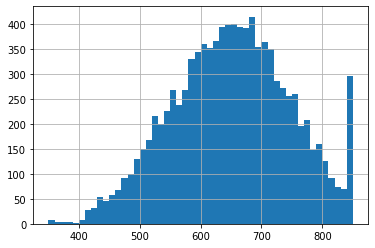

In [10]:
# просмотрим уникальные значений в столбце Surname
x = 'CreditScore'
print('Уникальные значения столбца {}:\n'.format(x), 
      data[x].unique(), '\n',
      '\nОбщее количество уникальных значений столбца {}:\n'.format(x), 
      data[x].nunique(), '\n',
      '\nКоличество уникальных значений столбца {}:\n{}'.
      format(x, data[x].value_counts()), '\n',
     '\nТаблица распределения значений столбца {}:\n{}'.
      format(x, data[x].describe()), '\n') 
data[x].hist(bins=50)

In [11]:
# просмотрим уникальные значений в столбце Surname
x = 'NumOfProducts'
print('Уникальные значения столбца {}:\n'.format(x), 
      data[x].unique(), '\n',
      '\nОбщее количество уникальных значений столбца {}:\n'.format(x), 
      data[x].nunique(), '\n',
      '\nКоличество уникальных значений столбца {}:\n{}'.
      format(x, data[x].value_counts()), '\n',
     '\nТаблица распределения значений столбца {}:\n{}'.
      format(x, data[x].describe()), '\n') 

Уникальные значения столбца NumOfProducts:
 [1 3 2 4] 
 
Общее количество уникальных значений столбца NumOfProducts:
 4 
 
Количество уникальных значений столбца NumOfProducts:
1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64 
 
Таблица распределения значений столбца NumOfProducts:
count    10000.000000
mean         1.530200
std          0.581654
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: NumOfProducts, dtype: float64 



Продолжим изучение таблицы. 

Проверим уникальные значения нужных нам столбцов


In [12]:
# просмотрим уникальные значений в столбце Surname
x = 'Surname'
print('Уникальные значения столбца {}:\n'.format(x), 
      data[x].unique(), '\n',
      '\nОбщее количество уникальных значений столбца {}:\n'.format(x), 
      data[x].nunique(), '\n',
      '\nКоличество уникальных значений столбца {}:\n{}'.
      format(x, data[x].value_counts()), '\n',
     '\nТаблица распределения значений столбца {}:\n{}'.
      format(x, data[x].describe()), '\n') 

Уникальные значения столбца Surname:
 ['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge'] 
 
Общее количество уникальных значений столбца Surname:
 2932 
 
Количество уникальных значений столбца Surname:
Smith       32
Martin      29
Scott       29
Walker      28
Brown       26
            ..
Inman        1
Septimus     1
Locke        1
Clifton      1
Rooke        1
Name: Surname, Length: 2932, dtype: int64 
 
Таблица распределения значений столбца Surname:
count     10000
unique     2932
top       Smith
freq         32
Name: Surname, dtype: object 



**Промежуточные выводы**: в столбце есть множество повторяющихся фамилий клиентов, есть риск появления дубликатов, поэтому нужно проверить на явные дубликаты таблицу.

In [13]:
# просмотрим уникальные значений в столбце Geography
x = 'Geography'
print('Уникальные значения столбца {}:\n'.format(x), 
      data[x].unique(), '\n',
      '\nОбщее количество уникальных значений столбца {}:\n'.format(x), 
      data[x].nunique(), '\n',
      '\nКоличество уникальных значений столбца {}:\n{}'.
      format(x, data[x].value_counts()), '\n',
     '\nТаблица распределения значений столбца {}:\n{}'.
      format(x, data[x].describe()), '\n') 

Уникальные значения столбца Geography:
 ['France' 'Spain' 'Germany'] 
 
Общее количество уникальных значений столбца Geography:
 3 
 
Количество уникальных значений столбца Geography:
France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64 
 
Таблица распределения значений столбца Geography:
count      10000
unique         3
top       France
freq        5014
Name: Geography, dtype: object 



**Промежуточные выводы**: распределение по странам небольшое, всего три страны, преимущественно клиенты из Франции, количество клиентов других стран распределно равномерно.

In [14]:
# просмотрим уникальные значений в столбце Gender
x = 'Gender'
print('Уникальные значения столбца {}:\n'.format(x), 
      data[x].unique(), '\n',
      '\nОбщее количество уникальных значений столбца {}:\n'.format(x), 
      data[x].nunique(), '\n',
      '\nКоличество уникальных значений столбца {}:\n{}'.
      format(x, data[x].value_counts()), '\n',
     '\nТаблица распределения значений столбца {}:\n{}'.
      format(x, data[x].describe()), '\n') 

Уникальные значения столбца Gender:
 ['Female' 'Male'] 
 
Общее количество уникальных значений столбца Gender:
 2 
 
Количество уникальных значений столбца Gender:
Male      5457
Female    4543
Name: Gender, dtype: int64 
 
Таблица распределения значений столбца Gender:
count     10000
unique        2
top        Male
freq       5457
Name: Gender, dtype: object 



**Промежуточные выводы**: столбец пола предствлен двумя значениями, распредление полов примерно одинаково.

In [15]:
# просмотрим уникальные значений в столбце Tenure
x = 'Tenure'
print('Уникальные значения столбца {}:\n'.format(x), 
      data[x].unique(), '\n',
      '\nОбщее количество уникальных значений столбца {}:\n'.format(x), 
      data[x].nunique(), '\n',
      '\nКоличество уникальных значений столбца {}:\n{}'.
      format(x, data[x].value_counts()), '\n',
     '\nТаблица распределения значений столбца {}:\n{}'.
      format(x, data[x].describe()), '\n') 

Уникальные значения столбца Tenure:
 [ 2.  1.  8.  7.  4.  6.  3. 10.  5.  9.  0. nan] 
 
Общее количество уникальных значений столбца Tenure:
 11 
 
Количество уникальных значений столбца Tenure:
1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64 
 
Таблица распределения значений столбца Tenure:
count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64 



Можно отметить, что среднее значение данного столбца соотносится с медианой, а значит, можно попробовать заменить пропущенные значения средним. Вероятно, пропуски были совершены случайно. Таким образом, заменим пропуски медианой.

In [16]:
data['Tenure'] = data['Tenure'].fillna(np.random.randint(0, 10))

**Промежуточные выводы**: имеющиеся пропуски столбца `Tenure` заменены на средние значения для дальнейшго обучения моделей.

In [17]:
# просмотрим уникальные значений в столбце Exited
x = 'Exited'
print('Уникальные значения столбца {}:\n'.format(x), 
      data[x].unique(), '\n',
      '\nОбщее количество уникальных значений столбца {}:\n'.format(x), 
      data[x].nunique(), '\n',
      '\nКоличество уникальных значений столбца {}:\n{}'.
      format(x, data[x].value_counts()), '\n',
     '\nТаблица распределения значений столбца {}:\n{}'.
      format(x, data[x].describe()), '\n') 

Уникальные значения столбца Exited:
 [1 0] 
 
Общее количество уникальных значений столбца Exited:
 2 
 
Количество уникальных значений столбца Exited:
0    7963
1    2037
Name: Exited, dtype: int64 
 
Таблица распределения значений столбца Exited:
count    10000.000000
mean         0.203700
std          0.402769
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Exited, dtype: float64 



**Промежуточные выводы**: всего два значения в целевом столбце. Это хорошо. Но видно, распределены они примерно как 1/3, что потребует различных подходов для уравновешения различий в выборке (взвешивание, укрупнение выборок, уменьшение преобладающей).

**Выводы**: . Значения целевого стобца готово для использования в обучении (имеется всего два значения 1 и 0), однако распределение этих значений неравномерно, что требует работы с их балансированием.Пропущенные значения заменены на средние значения соответствующего столбца. Таблица не имеет явных дубликатов. Готовность к дальнейшей работы - полная!

## Исследование задачи

Соберем новую таблицу из исходной, поместив в нее лишь нужные и информативные для нашей задачи столбцы.

In [18]:
data_target = data.drop(['Surname', 'CustomerId', 'RowNumber'], axis=1) # создаем целевую таблицу

In [19]:
data_target # посмотрим, какой она получилась

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


В таблице есть много значений, необходимо от них избавиться и не попасть в дамми-ловушку. Так, нам необходимо убрать категориальные признаки географиеческого расположения пользователя (столбец `Geography`), а также разделить значения столбца пола (`Gender`). При этом надо помнить, чтобы мы не попали в избыточные данные (дамми), для этого избавимся от одного из стобцов, имплицитно обучая будущую модель методом "исключения" необозначенного признака.

In [20]:
data_ohe = pd.get_dummies(data_target, drop_first=True) # прямое кодирование категориальных признаков

Разделим полученную кодированную таблицу на целевой признак и признаки для обучения.

In [21]:
features = data_ohe.drop(['Exited'], axis=1)
target = data_ohe['Exited']

Разбиваем выборки на тестовую и валидационную и обучающую.

In [22]:
features_train_test, features_valid, target_train_test, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=RS)

In [23]:
features_train, features_test, target_train, target_test = train_test_split(
    features_train_test, target_train_test, test_size=0.25, random_state=RS)

Проверим размеры получившихся выборок

In [24]:
print('Размер обучающей выборки: ', features_train.shape, 
      'Размер валидационной выборки: ', features_valid.shape, 
      'Размер тестовой выборки: ', features_test.shape, sep='\n')

Размер обучающей выборки: 
(5625, 11)
Размер валидационной выборки: 
(2500, 11)
Размер тестовой выборки: 
(1875, 11)


Посмотрим для самоконтроля на полученную тренировочную выборку

In [25]:
features_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9315,694,42,8.0,133767.19,1,1,0,36405.21,0,0,1
58,511,66,4.0,0.00,1,1,0,1643.11,0,1,0
4609,581,34,1.0,0.00,2,0,1,81175.25,0,1,1
9958,537,37,6.0,0.00,1,1,1,17802.42,0,0,1
16,653,58,1.0,132602.88,1,1,0,5097.67,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1661,690,32,0.0,106683.52,2,1,1,137916.49,1,0,1
3419,674,26,10.0,0.00,2,1,1,138423.10,0,0,0
3148,648,39,6.0,130694.89,2,1,1,153955.38,0,0,0
5617,626,43,4.0,137638.69,1,1,0,130442.08,0,0,1


Чтобы избежать ошибки разномасштабных признаков, необходимо применить стандартизацию данных нужных нам столбцов.

In [26]:
numeric = ['CreditScore', 'Age', 'Balance', 'Tenure','EstimatedSalary'] # список нужных признаков для стандартизации

scaler = StandardScaler() # создадим модель стандартизации
scaler.fit(features_train[numeric]) # и обучим ее на тренировочных признаках

pd.options.mode.chained_assignment = None # избавимся от типового предупреждения

# заменим значения тренировочных, валидных и тестовых признаков на стандартизированные
features_train[numeric] = scaler.transform(features_train[numeric]) 
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Опять же посмотрим, как стала выглядеть таблица после стандартизации признаков

In [27]:
features_train.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9315,0.436123,0.302839,0.982637,0.932262,1,1,0,-1.121738,0,0,1
58,-1.458825,2.563332,-0.437359,-1.217770,1,1,0,-1.724514,0,1,0
4609,-0.733981,-0.450659,-1.502356,-1.217770,2,0,1,-0.345423,0,1,1
9958,-1.189597,-0.168097,0.272639,-1.217770,1,1,1,-1.444311,0,0,1
16,0.011572,1.809834,-1.502356,0.913549,1,1,0,-1.664612,1,0,1
3983,-0.268011,0.491213,-1.147357,-1.217770,1,0,1,1.248854,0,0,0
5408,0.311864,1.433085,-1.857355,0.117935,2,1,1,-0.814338,0,1,0
5218,0.342929,-1.769279,-0.437359,0.465388,2,1,0,-1.082096,0,0,1
1494,-2.100829,1.244711,0.627638,-1.217770,2,0,1,0.390605,0,0,1
8853,0.301509,0.397026,0.627638,-0.151512,1,1,1,-1.427489,0,0,1


**Выводы**: исходная таблица кодирована прямой кодировкой с избавлением от дамми-ловушки, разбита на три выборки (тренировочную, валидационную, тестовую), выжные для нас признаки стандартизированы для каждой выборки. Теперь можно приступать к обучению моделей.

### Рассмотрим три модели из курса: 
- "Случайный лес" - RandomForestClassifier;
- Дерево решений - DecisionTreeClassifier;
- Логистическая регрессия - LogisticRegression.

### Модель "случайный лес"

Вначале проведем обучение моделей без дополнительной балансироваки целевого признака и без дополнительных гиперпараметров.

In [28]:
model_rfc = RandomForestClassifier(random_state=RS)

In [29]:
model_rfc.fit(features_train, target_train)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

Выведем значение соотношения полноты и точности прогноза модели (F1-score) для модели с гиперпараметрами *по умолчанию*

In [30]:
predicted_valid = model_rfc.predict(features_valid)
f1_rfc_default = f1_score(target_valid, predicted_valid)

In [31]:
print('F1-score "случайного леса" без подбора гиперпараметров:', f1_rfc_default)

F1-score "случайного леса" без подбора гиперпараметров: 0.5333333333333333


**Промежуточные выводы**: значение соотношения неплохое (исходя из условий задачи), но попробуем его увеличить до необходимого значения с помощью подбора гиперпараметров.

#### Подберем гиперпараметры для нашей модели.

In [32]:
# Создадим словарь гиперпараметров для использования его в "сеточном переборе"
parameters_rfc = {'n_estimators': range (10, 200, 10), 'max_depth': range (1, 13, 2)}

In [33]:
grid_rfc = GridSearchCV(model_rfc, parameters_rfc, cv=5, n_jobs=-1)

In [34]:
grid_rfc.fit(features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=12345, verbose=0,
                                              warm_start=False),
             iid='w

In [35]:
print('Лучшие гиперпараметры для модели "случаного леса":', grid_rfc.best_params_)

Лучшие гиперпараметры для модели "случаного леса": {'max_depth': 11, 'n_estimators': 160}


Для тестирования запишем лучшие гиперпараметры для модели "случаного леса" в этой ячейке: {'max_depth': 11, 'n_estimators': 40}

Применим полученные гиперпараметры в нашей модели

In [36]:
%%timeit
model_rfc = RandomForestClassifier(random_state=RS, 
                                   n_estimators=grid_rfc.best_params_['n_estimators'],
                                   max_depth=grid_rfc.best_params_['max_depth'], n_jobs=-1)
model_rfc.fit(features_train, target_train) # обучим модель

773 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
predicted_valid = model_rfc.predict(features_valid) # сделаем предсказание на валиадционных данных
f1_rfc_hyper = f1_score(target_valid, predicted_valid)

In [38]:
print('F1-score "случайного леса" с лучшими гиперпараметрами:', f1_rfc_hyper)

F1-score "случайного леса" с лучшими гиперпараметрами: 0.5333333333333333


**Промежуточные выводы**: видно, что качество модели не улучшилось. Значит, дело в балансе признаков.

### Проверим другую модель - дерево решений

In [39]:
model_tree = DecisionTreeClassifier(random_state=RS)

In [40]:
model_tree.fit(features_train, target_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

Выведем значение соотношения полноты и точности прогноза модели (F1-score) для модели с гиперпараметрами *по умолчанию*

In [41]:
predicted_tree_valid = model_tree.predict(features_valid)
f1_tree_default = f1_score(target_valid, predicted_tree_valid)

In [42]:
print('F1-score дерева решений без подбора гиперпараметров:', f1_tree_default)

F1-score дерева решений без подбора гиперпараметров: 0.4779080252479711


**Промежуточные выводы**: значение соотношения ниже модели "случайного леса", попробуем его увеличить до необходимого значения с помощью подбора гиперпараметров.

### Подберем теперь гиперпараметры для модели дерева решений

In [43]:
parameters_tree = {'max_depth': range (1, 100, 2)} # вновь создадим словарь параметров

In [44]:
grid_tree = GridSearchCV(model_tree, parameters_tree, cv=5,  n_jobs=-1)

In [45]:
grid_tree.fit(features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=12345,
                                              splitter='best'),
             iid='warn', n_jobs=-1, param_grid={'max_depth': range(1, 100, 2)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scor

In [46]:
print('Лучшие гиперпараметры для модели дерева решений', grid_tree.best_params_)

Лучшие гиперпараметры для модели дерева решений {'max_depth': 5}


Оставим лучшие гиперпараметры для модели дерева решений для тестирования: {'max_depth': 5}

Используем найденные гиперпараметры в нашей модели.

In [47]:
model_tree = DecisionTreeClassifier(random_state=RS,
                                    max_depth=grid_tree.best_params_['max_depth'])

In [48]:
model_tree.fit(features_train, target_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

In [49]:
predicted_tree_valid = model_tree.predict(features_valid)
f1_tree_hyper = f1_score(target_valid, predicted_tree_valid)

In [50]:
print('F1-score дерева решений с лучшими гиперпараметрами:', f1_score(target_valid, predicted_tree_valid))

F1-score дерева решений с лучшими гиперпараметрами: 0.5531914893617023


**Промежуточные выводы**: значение соотношения стало значительно лучше и приблизилось к значению модели "случайного леса".

### Проверим модель логистической регрессии

In [51]:
model_log = LogisticRegression(random_state=RS, solver='liblinear')

In [52]:
model_log.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

In [53]:
predicted_log = model_log.predict(features_valid)
f1_log = f1_score(target_valid, predicted_log)

In [54]:
print('F1-score модели линейной регрессии:', f1_log)

F1-score модели линейной регрессии: 0.28449502133712656


**Промежуточные выводы**: значение соотношения весьма отстает от "деревянных моделей" - здесь точно нужен баланс признаков.

In [55]:
# создадим таблицу значений F1-score для каждой обученной модели
results_default = pd.DataFrame({'Вариация обучающей выборки': ['Случайное дерево без гиперпараметров', 
                                                               'Случайное дерево с гиперпараметрами', 
                                                               'Дерево решений без гиперпараметров', 
                                                               'Дерево решений с гиперпараметрами',
                                                               'Логистическая регрессия'
                                                              ],
                                'F1-score': [f1_rfc_default, f1_rfc_hyper, f1_tree_default, f1_tree_hyper, f1_log]}).sort_values(
                                       by='F1-score', ascending=False).reset_index(drop=True)
display('Таблица сравнения значений F1-score разных моделей на несбалансированных данных', results_default)

'Таблица сравнения значений F1-score разных моделей на несбалансированных данных'

,Вариация обучающей выборки,F1-score
0,Дерево решений с гиперпараметрами,0.553191
1,Случайное дерево без гиперпараметров,0.533333
2,Случайное дерево с гиперпараметрами,0.533333
3,Дерево решений без гиперпараметров,0.477908
4,Логистическая регрессия,0.284495


**Выводы**: как видно из финальной таблицы, лучшей моделью, обученой на несбалансированной выборке, оказалась модель дерева решений с подобранными гиперпарамтрами, от значений F1-score которой незначительно отстают модели "случайного леса. Модель логистической регрессии обучена плохо.

## Борьба с дисбалансом

Применим различные методы работы с дисбалансом классов.

## а) Взвешивание классов.

### Модель "случайного леса" со взвешиванием

In [56]:
# создадим отдельную модель с новыми условиями значений весов
model_rfc_balanced = RandomForestClassifier(random_state=RS, 
                                            n_estimators=grid_rfc.best_params_['n_estimators'],
                                            max_depth=grid_rfc.best_params_['max_depth'],
                                            class_weight='balanced')

In [57]:
model_rfc_balanced.fit(features_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=160, n_jobs=None, oob_score=False,
                       random_state=12345, verbose=0, warm_start=False)

In [58]:
predicted_rfc_valid = model_rfc_balanced.predict(features_valid)

In [59]:
print('F1-score "случайного леса" со взвешенной обучающей выборкой:', f1_score(target_valid, predicted_rfc_valid))

F1-score "случайного леса" со взвешенной обучающей выборкой: 0.6195761856710394


**Промежуточные выводы**: значение F1 гораздо лучше и выше необходимого.

### Модель дерева решений со взвешиванием

In [60]:
# создадим отдельную модель и для дерева решений с новыми условиями значений весов
model_tree_balanced = DecisionTreeClassifier(random_state=RS,
                                             max_depth=grid_tree.best_params_['max_depth'],
                                             class_weight='balanced')

In [61]:
model_tree_balanced.fit(features_train, target_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

In [62]:
predicted_tree_valid = model_tree_balanced.predict(features_valid)

In [63]:
print('F1-score модели дерева решений со взвешенной обучающей выборкой:', f1_score(target_valid, predicted_tree_valid))

F1-score модели дерева решений со взвешенной обучающей выборкой: 0.5818908122503329


**Промежуточные выводы**: значение F1 гораздо лучше и приблизилось к необходимому по задаче, но уступает модели "случайного леса".

### Модель логистической регрессии со взвешиванием

In [64]:
model_log_balanced = LogisticRegression(random_state=RS, solver='liblinear', class_weight='balanced')

In [65]:
model_log_balanced.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

In [66]:
predicted_log = model_log_balanced.predict(features_valid)

In [67]:
print('F1-score модели линейной регрессии со взвешенной обучающей выборкой:', f1_score(target_valid, predicted_log))

F1-score модели линейной регрессии со взвешенной обучающей выборкой: 0.507343124165554


**Промежуточные выводы**: значение F1 достаточно сильно увеличилось у модели логистической регресси - видимо, взвешивание признаков существенно повышает точность предсказания.

## б) Укрупнение выборки.

Для укрупнения выборки воспользуемся подходом upsampling.

In [68]:
# функция для отсеивания и укрупнения каждого признака на произвольное значение repeat
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RS)
    
    return features_upsampled, target_upsampled

Применим функцию укрупнения признаков к нашей тренировочной (обучающей) выборке и создадим новые увеличенные по размеру признаки

In [69]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

Полученные укрупненные признаки будем применять к различным моделям обучения.

### Проверка на случайных деревьях

In [70]:
model_rfc_up = RandomForestClassifier(random_state=RS, 
                                   n_estimators=grid_rfc.best_params_['n_estimators'],
                                   max_depth=grid_rfc.best_params_['max_depth'])
model_rfc_up.fit(features_upsampled, target_upsampled)
predicted_rfc_valid = model_rfc_up.predict(features_valid)
print('F1-score "случайного леса" с увеличением обучающей выборки:', f1_score(target_valid, predicted_rfc_valid))

F1-score "случайного леса" с увеличением обучающей выборки: 0.5819444444444445


**Промежуточные выводы**: значение F1 не увеличилось по сравнению с подходом взвешивания классов.

### Проверка дерева решений

In [71]:
model_tree_up = DecisionTreeClassifier(random_state=RS,
                                    max_depth=grid_tree.best_params_['max_depth'])
model_tree_up.fit(features_upsampled, target_upsampled)
predicted_tree_valid = model_tree_up.predict(features_valid)
print('F1-score дерева решений с увеличением обучающей выборки:', f1_score(target_valid, predicted_tree_valid))

F1-score дерева решений с увеличением обучающей выборки: 0.5205479452054794


**Промежуточные выводы**: значение F1 уменьшилось в сравнении со взвешенными признаками.

### Проверка логистической регрессии

In [72]:
model_log_up = LogisticRegression(random_state=RS, solver='liblinear')
model_log_up.fit(features_upsampled, target_upsampled)
predicted_log_valid = model_log_up.predict(features_valid)
print('F1-score модели линейной регрессии с увеличением обучающей выборки:', f1_score(target_valid, predicted_log_valid))

F1-score модели линейной регрессии с увеличением обучающей выборки: 0.42213642213642216


**Промежуточные выводы**: значение F1 также упало.

## в) Уменьшение выборки.

Для уменьшения преобладающего признака выборки воспользуемся подходом downsampling.

In [73]:
# функция для уменьшения избыточного признака на произвольное значение fraction

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=RS)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=RS)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=RS)
    
    return features_downsampled, target_downsampled

In [74]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

Полученные уменьшенные преобладающие признаки будем применять к различным моделям обучения.

### Проверка на случайных деревьях

In [75]:
model_rfc_dwn = RandomForestClassifier(random_state=RS, 
                                   n_estimators=grid_rfc.best_params_['n_estimators'],
                                   max_depth=grid_rfc.best_params_['max_depth'])
model_rfc_dwn.fit(features_downsampled, target_downsampled)
predicted_rfc_valid = model_rfc_dwn.predict(features_valid)
print('F1-score "случайного леса" с уменьшением обучающей выборки:', f1_score(target_valid, predicted_rfc_valid))

F1-score "случайного леса" с уменьшением обучающей выборки: 0.48496796451453916


**Промежуточные выводы**: значение F1 сильно снизилось по сравнению с подходом взвешивания классов.

### Проверка на дереве решений

In [76]:
model_tree_dwn = DecisionTreeClassifier(random_state=RS,
                                    max_depth=grid_tree.best_params_['max_depth'])
model_tree_dwn.fit(features_downsampled, target_downsampled)
predicted_tree_valid = model_tree_dwn.predict(features_valid)
print('F1-score дерева решений с уменьшением обучающей выборки:', f1_score(target_valid, predicted_tree_valid))

F1-score дерева решений с уменьшением обучающей выборки: 0.5045045045045046


**Промежуточные выводы**: значение F1 также снизилось по сравнению с подходом взвешивания классов.

### Проверка логистической регрессии

In [77]:
model_log_dwn = LogisticRegression(random_state=RS, solver='liblinear')
model_log_dwn.fit(features_downsampled, target_downsampled)
predicted_log_valid = model_log_dwn.predict(features_valid)
print('F1-score модели линейной регрессии с уменьшением обучающей выборки:', f1_score(target_valid, predicted_log_valid))

F1-score модели линейной регрессии с уменьшением обучающей выборки: 0.42567858681602755


**Промежуточные выводы**: значение F1 также не увеличилось по сравнению с подходом взвешивания классов и в логистической регрессии.

**Выводы**: получены различные значения F1-score с применением различных методов борьбы с дисбалансом признаков. Лучшие результаты показывал метод взвешивания классов. Однако, проверим, какие из обученных моделей справятся лучше с тестовыми данными.

# Тестирование модели

Найдем лучшую вариацию модели "случайного леса" на тестовой выборке

Для более наглядного сравнения создадим таблицу всех ранее изученных моделей при работе с тестовой выборкой, определим лучшую из них для каждого вида модели и сравним их значения AUC-ROC между собой. Ну а затем изобразим их  ROC-кривые на одном графике для наглядного сравнения.

### Сравнение работы всех моделей "случайного леса" на тестовой выборке

In [78]:
# запишем все предсказания каждой модели, обученной выше
predicted_rfc_test_disbalanced = model_rfc.predict(features_test)
predicted_rfc_test_balanced = model_rfc_balanced.predict(features_test)
predicted_rfc_test_up = model_rfc_up.predict(features_test)
predicted_rfc_test_dwn = model_rfc_dwn.predict(features_test)

# создадим таблицу значений F1-score для каждой обученной модели
rfc_score = pd.DataFrame({'Вариация обучающей выборки': ['default', 'balanced', 'upsampled', 'downsampled'],
                          'F1-score': [f1_score(target_test, predicted_rfc_test_disbalanced),
                                       f1_score(target_test, predicted_rfc_test_balanced),
                                       f1_score(target_test, predicted_rfc_test_up),
                                       f1_score(target_test, predicted_rfc_test_dwn)]}).sort_values(
                                       by='F1-score', ascending=False).reset_index(drop=True)
# выделим лучший результат значения F1-score
best_rfc_result = rfc_score['F1-score'].max()

# выведем полученные результаты на экран
display('Таблица значений модели случайного леса на различных выборках', rfc_score)
print('Вывод - лучшая модель "случайного дерева" со значением F1-score {} обучена на выборке: {}'.format(
      best_rfc_result, rfc_score['Вариация обучающей выборки'][0]))

'Таблица значений модели случайного леса на различных выборках'

,Вариация обучающей выборки,F1-score
0,balanced,0.602778
1,upsampled,0.590693
2,default,0.549918
3,downsampled,0.465969


Вывод - лучшая модель "случайного дерева" со значением F1-score 0.6027777777777777 обучена на выборке: balanced


**Промежуточные выводы**: модель "случайного леса", обученная на взвешенной выборке `balanced` и с подобранными гиперпараметрами выдает необходимую по условиям задачи предсказательную силу - модель достаточно обучена.

In [79]:
# создадим словарь соответствия значений F1-score и соответствующей модели для вычленения лучшей обученной модели
rfc_score_dict = {f1_score(target_test, predicted_rfc_test_disbalanced): model_rfc,
                   f1_score(target_test, predicted_rfc_test_balanced): model_rfc_balanced,
                   f1_score(target_test, predicted_rfc_test_up): model_rfc_up,
                   f1_score(target_test, predicted_rfc_test_dwn): model_rfc_dwn}

# сохраним лучшую обученную модель в качестве финальной в переменную
final_rfc_model = rfc_score_dict[best_rfc_result]

### Проверим значение AUC-ROC для лучшей модели "случайного дерева"

In [80]:
# проверим значения AUC-ROC для лучшей модели "случайного дерева"
probabilities_test = final_rfc_model.predict_proba(features_test)
probabilities_one_rfc_test = probabilities_test[:, 1]
auc_roc_rfc = roc_auc_score(target_test, probabilities_one_rfc_test)

# выведем полученные результаты на экран
print('Значение AUC-ROC лучшей вариации модели "случайного леса" на тестовой выборке:', auc_roc_rfc)

Значение AUC-ROC лучшей вариации модели "случайного леса" на тестовой выборке: 0.8667840168984333


**Промежуточные выводы**: значение AUC-ROC (соотношения истинно положительных и ложно отрицательных значений) довольно высокое - модель хорошо обучена.

### Проверка точности дерева решений на тестовой выборке

In [81]:
# запишем все предсказания каждой модели, обученной выше
predicted_tree_disbalanced_test = model_tree.predict(features_test)
predicted_tree_balanced_test = model_tree_balanced.predict(features_test)
predicted_tree_up_test = model_tree_up.predict(features_test)
predicted_tree_dwn_test = model_tree_dwn.predict(features_test)

# создадим таблицу значений F1-score для каждой обученной модели
tree_score = pd.DataFrame({'Вариация обучающей выборки': ['default', 'balanced', 'upsampled', 'downsampled'],
                          'F1-score': [f1_score(target_test, predicted_tree_disbalanced_test),
                                       f1_score(target_test, predicted_tree_balanced_test),
                                       f1_score(target_test, predicted_tree_up_test),
                                       f1_score(target_test, predicted_tree_dwn_test)]}).sort_values(
                                       by='F1-score', ascending=False).reset_index(drop=True)

# выделим лучший результат значения F1-score
best_tree_result = tree_score['F1-score'].max()

# выведем полученные результаты на экран
display('Таблица значений модели "дерево решений" на различных выборках', tree_score)
print('Лучшая модель дерева решений со значением F1-score {} обучена на выборке: {}'.format(
      best_tree_result, tree_score['Вариация обучающей выборки'][0]))

'Таблица значений модели "дерево решений" на различных выборках'

,Вариация обучающей выборки,F1-score
0,default,0.558442
1,balanced,0.556940
2,upsampled,0.503391
3,downsampled,0.497101


Лучшая модель дерева решений со значением F1-score 0.5584415584415585 обучена на выборке: default


**Промежуточные выводы**: модель дерева решений, обученная на несбалансированной выборке `default` с подобранными гиперпараметрами выдает недостаточную предсказательную силу по условиям задачи  - модель недостаточно обучена.

In [82]:
# создадим словарь соответствия значений F1-score и соответствующей модели для вычленения лучшей обученной модели
tree_score_dict = {f1_score(target_test, predicted_tree_disbalanced_test): model_tree,
                   f1_score(target_test, predicted_tree_balanced_test): model_tree_balanced,
                   f1_score(target_test, predicted_tree_up_test): model_tree_up,
                   f1_score(target_test, predicted_tree_dwn_test): model_tree_dwn}

# сохраним лучшую обученную модель в качестве финальной в переменную
final_tree_model = tree_score_dict[best_tree_result]

### Проверим значение AUC-ROC на лучшей вариации модели "Дерева решений"

In [83]:
# проверим значения AUC-ROC для лучшей модели дерева решений
probabilities_test = final_tree_model.predict_proba(features_test)
probabilities_one_tree_test = probabilities_test[:, 1]
auc_roc_tree = roc_auc_score(target_test, probabilities_one_tree_test)

# выведем полученные результаты на экран
print('AUC-ROC лучшей вариации модели дерева решений на тестовой выборке', auc_roc_tree)

AUC-ROC лучшей вариации модели дерева решений на тестовой выборке 0.8386085196268263


**Промежуточные выводы**: значение AUC-ROC (соотношения истинно положительных и ложно отрицательных значений) довольно высокое, однако модель обучена хуже, чем модель "случайного леса".

### Проверка логистической регрессии на тестовой выборке

In [84]:
# запишем все предсказания каждой модели, обученной выше
predicted_log_disbalanced_test = model_log.predict(features_test)
predicted_log_balanced_test = model_log_balanced.predict(features_test)
predicted_log_up_test = model_log_up.predict(features_test)
predicted_log_dwn_test = model_log_dwn.predict(features_test)

# создадим таблицу значений F1-score для каждой обученной модели
log_score = pd.DataFrame({'Вариация обучающей выборки': ['default', 'balanced', 'upsampled', 'downsampled'],
                          'F1-score': [f1_score(target_test, predicted_log_disbalanced_test),
                                       f1_score(target_test, predicted_log_balanced_test),
                                       f1_score(target_test, predicted_log_up_test),
                                       f1_score(target_test, predicted_log_dwn_test)]}).sort_values(
                                       by='F1-score', ascending=False).reset_index(drop=True)

# выделим лучший результат значения F1-score
best_log_result = log_score['F1-score'].max()

# выведем полученные результаты на экран
display('Таблица значений модели логистической регрессии на различных выборках', log_score)
print('Лучшая модель логистической регрессии со значением F1-score {} обучена на выборке: {}'.format(
      best_log_result, log_score['Вариация обучающей выборки'][0]))


'Таблица значений модели логистической регрессии на различных выборках'

,Вариация обучающей выборки,F1-score
0,balanced,0.522233
1,downsampled,0.421053
2,upsampled,0.419597
3,default,0.309804


Лучшая модель логистической регрессии со значением F1-score 0.5222327341532639 обучена на выборке: balanced


**Промежуточные выводы**: модель логистической регрессии, обученная на взвешенной выборке `balanced` показывает недостаточную предсказательную силу по условиям задачи - модель недостаточно обучена.

In [85]:
# создадим словарь соответствия значений F1-score и соответствующей модели для вычленения лучшей обученной модели
log_score_dict = {f1_score(target_test, predicted_log_disbalanced_test): model_log,
                   f1_score(target_test, predicted_log_balanced_test): model_log_balanced,
                   f1_score(target_test, predicted_log_up_test): model_log_up,
                   f1_score(target_test, predicted_log_dwn_test): model_log_dwn}

# сохраним лучшую обученную модель в качестве финальной в переменную
final_log_model = log_score_dict[best_log_result]

### Проверим значение AUC-ROC на лучшей вариации модели линейной регрессии

In [86]:
# проверим значения AUC-ROC для лучшей модели логистической регрессии
probabilities_test = final_log_model.predict_proba(features_test)
probabilities_one_log_test = probabilities_test[:, 1]
auc_roc_log = roc_auc_score(target_test, probabilities_one_log_test)

# выведем полученные результаты на экран
print('AUC-ROC лучшей вариации модели логистической регрессии на тестовой выборке', auc_roc_log)

AUC-ROC лучшей вариации модели логистической регрессии на тестовой выборке 0.7943249427917619


**Промежуточные выводы**: значение AUC-ROC (соотношения истинно положительных и ложно отрицательных значений) ниже, чем у моделей "случайного леса" и дерева решений.

### Создадим таблицу соотношений значений AUC-ROC различных лучших моделей на тестовой выборке

In [87]:
# создаем таблицу, в которую занесем значения AUC-ROC различных лучших моделей
auc_roc_score = pd.DataFrame({'Модели': ['"случайное дерево"', 'дерево решений', 'логистическая регрессия'],
                          'Значение AUC-ROC': [auc_roc_rfc, auc_roc_tree, auc_roc_log]}).sort_values(
                                       by='Значение AUC-ROC', ascending=False).reset_index(drop=True)

# обозначим лучший результат и сохраним его в переменную
best_auc_roc_result = auc_roc_score['Значение AUC-ROC'].max()

# выведем таблицу и вывод на экран
display('Таблица значений кривой ошибок (AUC-ROC) для различных моделей', auc_roc_score)
print('Лучший результат у модели {} со значением AUC-ROC: {}'.format(auc_roc_score['Модели'][0], 
                                                                     best_auc_roc_result))



'Таблица значений кривой ошибок (AUC-ROC) для различных моделей'

,Модели,Значение AUC-ROC
0,"""случайное дерево""",0.866784
1,дерево решений,0.838609
2,логистическая регрессия,0.794325


Лучший результат у модели "случайное дерево" со значением AUC-ROC: 0.8667840168984333


### Построим кривые ROC работы каждой модели обучения на тестовой выборке на одном графике


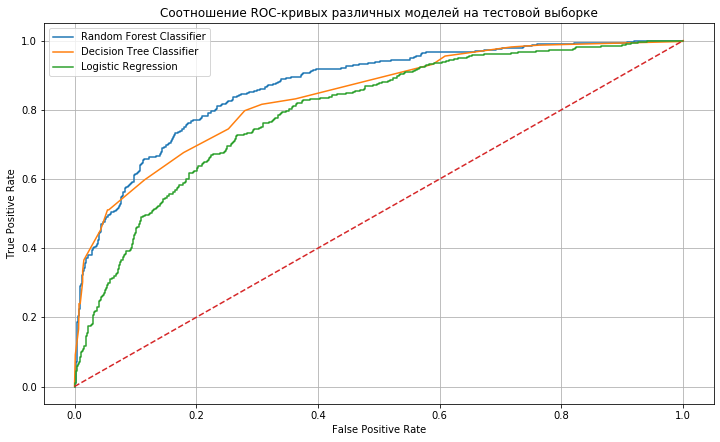

In [88]:
fpr_rfc, tpr_rfc, thresholds = roc_curve(target_test, probabilities_one_rfc_test)
fpr_tree, tpr_tree, thresholds = roc_curve(target_test, probabilities_one_tree_test)
fpr_log, tpr_log, thresholds = roc_curve(target_test, probabilities_one_log_test)

fig, ax = plt.subplots(figsize=(12, 7))                                           
ax.plot(fpr_rfc, tpr_rfc, label='Random Forest Classifier') 
ax.plot(fpr_tree, tpr_tree, label='Decision Tree Classifier') 
ax.plot(fpr_log, tpr_log, label='Logistic Regression')
ax.plot([0, 1], [0, 1], linestyle='--')

ax.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Соотношение ROC-кривых различных моделей на тестовой выборке')
ax.legend()

**Выводы**: исходя из приведенных выше таблиц и графиков видно, что лучшей моделью является модель "случайного леса", обученная на взвешенных признаках с подобранными гиперпараметрами. Далее следует модель дерева решений, которая лучше отработала на невзвешенных признаках с подобранными гиперпараметрами. Хуже всего справлялась модель логистической регрессии с предсказаниями как на валидационной выборке, так и на тестовой.

# Общие выводы

В ходе работы над проектом были выполнены следующие шаги:
1. Просмотрена общая информация таблицы исходных данных, проверены уникальные значения, пропуски, количество `NaN` значений.
2. Были заменены пропуски в столбце `Tenure` с заменой на среднее значение.
3. Была создана *целевая таблица* с нужными признаками, проведена обработка значений методом прямой кодировки с избеганием дамми-ловушки, случайным образом отобраны три выборки (тренировочная, валидационная, тестовая) в соотношении 50/25/25, признаки в которых были стандартизованы.
4. Проверены три модели обучения как без подбора гиперпараметров, так и с их перебором, где было возможно методом автоматического подбора гиперпараметров (`GridSearchCV`).
5. Обученые модели были проверены на валидационной и тестовой выборках.
6. Были изучены метрики F1-score на каждом этапе проверки работоспособности моделей (как на валидационных, так и на тестовых выборках)
7. Были изучены значения AUC-ROC всех рассматриваемых моделей на тестовой выборке.
8. Все значения (F1-score, AUC-ROC) были занесены в таблицы для удобства сравнения.
9. Были отражены ROC-кривые для различных моделей, отработавших на тестовой выборке, на одном графике для удобства сравнения.
10. На каждом этапе были сделаны промежуточные выводы, где это было необходимо, а также были подведены краткие выводы в крупных модулях проекта.

По результатам работы над проектом можно сделать следующие выводы:
- наиболее высокая точность прогноза была представлена моделью "случайный лес", которая достигла необходимых по задаче (с небольшим превышением от требуемых);
- плохо обученной моделью оказалась модель логистической регрессией;
- значение AUC-ROC также было выше у модели "случайного леса" по сравнению с остальными моделями.

Возможные идеи улучшения обучения моделей:
- представляется вероятным улучшение модели обучения за счет увеличения изначальных данных;
- также, вероятно, модель будет показывать разлчиную точность обучения в зависимости от соотношения тренировочной и валидационной выборки;
- улучшение предсказательной силы, вероятно, будет тем выше, чем более равномерно распределены целевые признаки в соответствии с обучающими.

## Альтернативная работа по улучшению значения метрик

### Проверка финальной модели на большей выборке

Проведем тестирование различных моделей случайного дерева на тестовой выборке, обученной на бОльших данных, а именно, до разделения на валидационную. 

In [89]:
features_train_alternate = pd.concat([features_train, features_valid], ignore_index=True)
target_train_alternate = pd.concat([target_train, target_valid], ignore_index=True)

In [90]:
model_rfc_balanced_alternate = RandomForestClassifier(random_state=RS, 
                                            n_estimators=grid_rfc.best_params_['n_estimators'],
                                            max_depth=grid_rfc.best_params_['max_depth'],
                                            class_weight='balanced')
model_rfc_balanced_alternate.fit(features_train_alternate, target_train_alternate)

# запишем предсказания финальной модели, обученной выше
predicted_rfc_test_balanced_alternate = model_rfc_balanced_alternate.predict(features_test)

# создадим таблицу значений F1-score для финальной модели
rfc_score_alternate = pd.DataFrame({'Вариация обучающей выборки': ['Финальная модель "случайного леса"', 
                                                                   'Финальная модель "случайного леса"'],
                                    'Размер обучающей выборки': [features_train_alternate.shape[0],
                                                                 features_train.shape[0]],
                                    'F1-score': [f1_score(target_test, predicted_rfc_test_balanced_alternate), 
                                                 f1_score(target_test, predicted_rfc_test_balanced)]})
# выделим лучший результат значения F1-score
alternate_result_model_result = rfc_score_alternate['F1-score'].max()

# выведем полученные результаты на экран
display('Сравнение значений финальной модели случайного леса на различных размерах обучающих данных', 
        rfc_score_alternate)


'Сравнение значений финальной модели случайного леса на различных размерах обучающих данных'

,Вариация обучающей выборки,Размер обучающей выборки,F1-score
0,"Финальная модель ""случайного леса""",8125,0.620506
1,"Финальная модель ""случайного леса""",5625,0.602778


**Промежуточный вывод**: финальная модель показывает лучшие предсказания на тестовой выборке при увеличении обучающей выборки.

Проверим значения AUC-ROC для финальной модели с различным размером обучаеющей выборки

In [91]:
probabilities_test_alternate = model_rfc_balanced_alternate.predict_proba(features_test)
probabilities_one_alternate_test = probabilities_test_alternate[:, 1]
auc_roc_alternate = roc_auc_score(target_test, probabilities_one_alternate_test)


# создаем таблицу, в которую занесем значения AUC-ROC различных лучших моделей
auc_roc_score_final = pd.DataFrame({'Размер выборки': ['Большая обучающая выборка', 'Малая обучающая выборка'],
                                    'Значение AUC-ROC': [auc_roc_alternate, auc_roc_rfc]}).sort_values(
    by='Значение AUC-ROC', ascending=False).reset_index(drop=True).reset_index(drop=True)

# обозначим лучший результат и сохраним его в переменную
best_auc_roc = auc_roc_score_final['Значение AUC-ROC'].max()

# выведем таблицу и вывод на экран
display('Таблица значений кривой ошибок (AUC-ROC) с различным размером обучающих выборок финальной модели', 
        auc_roc_score_final)
print('Лучший результат у модели с выборокой: {}. Значение AUC-ROC: {}'.format(
       auc_roc_score_final['Размер выборки'][0], best_auc_roc_result))



'Таблица значений кривой ошибок (AUC-ROC) с различным размером обучающих выборок финальной модели'

,Размер выборки,Значение AUC-ROC
0,Большая обучающая выборка,0.872855
1,Малая обучающая выборка,0.866784


Лучший результат у модели с выборокой: Большая обучающая выборка. Значение AUC-ROC: 0.8667840168984333


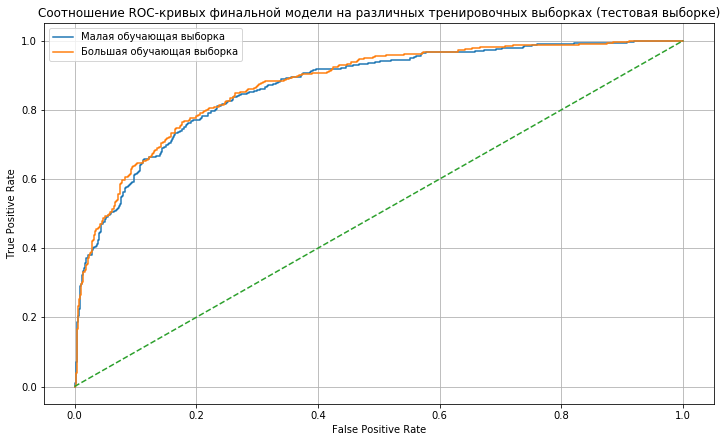

In [92]:
fpr_rfc, tpr_rfc, thresholds = roc_curve(target_test, probabilities_one_rfc_test)
fpr_rfc_alternate, tpr_rfc_alternate, thresholds = roc_curve(target_test, probabilities_one_alternate_test)

fig, ax = plt.subplots(figsize=(12, 7))                                           
ax.plot(fpr_rfc, tpr_rfc, label='Малая обучающая выборка') 
ax.plot(fpr_rfc_alternate, tpr_rfc_alternate, label='Большая обучающая выборка') 
ax.plot([0, 1], [0, 1], linestyle='--')

ax.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Соотношение ROC-кривых финальной модели на различных тренировочных выборках (тестовая выборке)')
ax.legend()

**Промежуточные выводы**: финальня модель "случайного леса" имеет незначительные, но все же более высокие значения AUC-ROC, значит модель с большей обучающей выборкой более точно предсказываает результаты. 

**Выводы**: 

### Проверим значимость каждого фактора на результат


Попробуем оценить значимость каждого фактора, на который "обращала внимание" модель при работе с валидационной выборке.

In [93]:
perm = PermutationImportance(final_rfc_model, random_state=RS).fit(features_valid, target_valid)
eli5.show_weights(perm, feature_names = features_valid.columns.tolist())

Weight,Feature
0.0846 ± 0.0056,Age
0.0627 ± 0.0073,NumOfProducts
0.0258 ± 0.0040,IsActiveMember
0.0182 ± 0.0055,Balance
0.0159 ± 0.0026,Geography_Germany
0.0027 ± 0.0016,Gender_Male
0.0001 ± 0.0016,HasCrCard
-0.0010 ± 0.0015,Geography_Spain
-0.0014 ± 0.0030,EstimatedSalary
-0.0026 ± 0.0038,Tenure


**Выводы**: как оказалось, наиболее значимыми для прогноза модель "выбрала" возрасть клиента, количество продуктов в у клиента в банке, активность клиентского счета и баланс на счету. Менее значимыми оказались предполагаемая зарплата, кредитный рейтинг и время пользования клиентом услуг банка.

### Вычиление метрик полноты и точности на альтернативной финальной модели

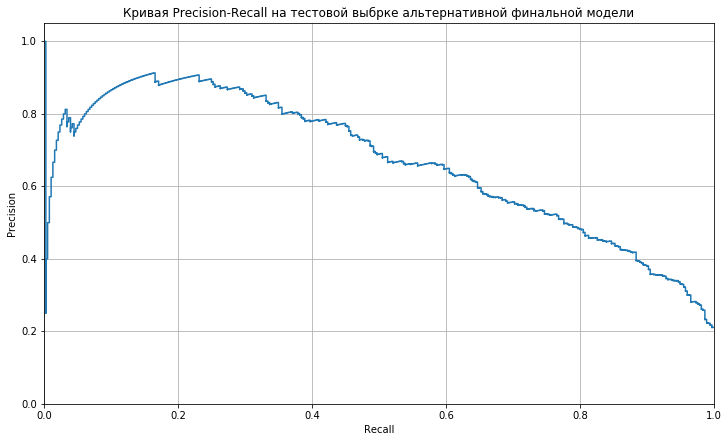

In [94]:
probabilities_test = model_rfc_balanced_alternate.predict_proba(features_test)
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_test[:, 1])

plt.figure(figsize=(12, 7))
plt.step(recall, precision, where='post')
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall на тестовой выбрке альтернативной финальной модели')
plt.show() 

**Выводы**: как видим, кривая соотношения полноты и точности достаточно высока, что говорит о достаточно хорошо обученной финальной модели.


## Дополнительные выводы

1. При обучении модели на большей выборке ее точность повышается.
2. Была определна значимость некоторых признаков, на которые опиралась модель для прогноза. Ими оказались возраст клиента, количество продуктов у клиента в банке, активность клиентского счета и баланс на счету. Менее значимыми оказались предполагаемая зарплата клиента, его кредитный рейтинг и время пользования клиентом услуг банка.
3. Кривая соотношения полноты и точности обученной модели достаточно высока, что говорит о хорошо обученой модели.